In [56]:
# Cell 1 – Imports & basic config

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Optional: nicer plots
sns.set(style="whitegrid")

In [57]:
# Cell 2 — Load data & merge (clean version)

# --- Load dispersion factors ---
df_factors = pd.read_csv("data2/dispersion_factors.csv")

# Convert date
df_factors["date"] = pd.to_datetime(df_factors["date_ny"], format="%Y-%m-%d")

# Keep only required columns (keep gracefully only those that exist)
cols_keep = [
    "date", "F1", "F2", "F3",
    "F1_z60", "F2_z60", "F3_z60",
    "Dispersion_Z_60d",
]

df_factors = df_factors[[c for c in cols_keep if c in df_factors.columns]].copy()

# --- Load SPY prices (from merged daily file) ---
df_spy = pd.read_csv("data2/SPY_options_daily_merged.csv")
df_spy["date"] = pd.to_datetime(df_spy["date_ny"])

df_spy = df_spy[["date", "S_close"]]

# --- Merge the two datasets (inner = intersecting days only) ---
df = (
    pd.merge(df_factors, df_spy, on="date", how="inner")
    .sort_values("date")
    .reset_index(drop=True)
)

print("Final DataFrame shape:", df.shape)
df.tail()

Final DataFrame shape: (1373, 9)


,date,F1,F2,F3,F1_z60,F2_z60,F3_z60,Dispersion_Z_60d,S_close
1368,2025-12-01,0.676074,0.190830,0.919291,0.591211,-0.621844,-0.419293,-0.298213,680.27
1369,2025-12-02,0.649689,0.187593,0.937887,0.309099,-0.659205,-0.177872,-0.273011,681.53
1370,2025-12-03,0.548716,0.198387,0.959157,-0.720638,-0.519070,0.086192,-0.317279,683.89
1371,2025-12-04,0.494306,0.179859,0.927502,-1.231222,-0.752251,-0.301910,-0.667909,684.39
1372,2025-12-05,0.319332,0.239480,1.070128,-2.751807,0.000781,1.390086,0.005985,685.69


In [58]:
# Cell 3 – Sanity checks

print("Columns:\n", df.columns.tolist())
print("\nDate range:", df["date"].min(), "→", df["date"].max())

for col in ["Dispersion_Z_60d", "F2_z60", "F3_z60"]:
    if col in df.columns:
        na_pct = df[col].isna().mean() * 100
        print(f"{col}: NaN = {na_pct:.2f}%")
    else:
        print(f"{col}: NOT FOUND in df.columns")

Columns:
 ['date', 'F1', 'F2', 'F3', 'F1_z60', 'F2_z60', 'F3_z60', 'Dispersion_Z_60d', 'S_close']

Date range: 2020-06-01 00:00:00 → 2025-12-05 00:00:00
Dispersion_Z_60d: NaN = 2.84%
F2_z60: NaN = 2.84%
F3_z60: NaN = 2.84%


In [60]:
# Cell 4 – Forward returns & crash flags

df["ret_1d"] = df["S_close"].shift(-1) / df["S_close"] - 1
df["ret_2d"] = df["S_close"].shift(-2) / df["S_close"] - 1
df["ret_3d"] = df["S_close"].shift(-3) / df["S_close"] - 1

# Drop rows at the end with no future returns
df_bt = df.dropna(subset=["ret_1d", "ret_2d", "ret_3d"]).reset_index(drop=True)

print("Backtest sample size:", len(df_bt))
df_bt.tail()

Backtest sample size: 1370


,date,F1,F2,F3,F1_z60,F2_z60,F3_z60,Dispersion_Z_60d,S_close,ret_1d,ret_2d,ret_3d
1365,2025-11-25,0.692113,0.156894,0.888281,0.679885,-1.122612,-0.802217,-0.633955,675.02,0.006903,0.012400,0.007778
1366,2025-11-26,0.422447,0.126646,0.946893,-1.994183,-1.472982,-0.103266,-1.029336,679.68,0.005458,0.000868,0.002722
1367,2025-11-28,0.551870,0.200708,1.029908,-0.677033,-0.505781,0.887957,0.017464,683.39,-0.004565,-0.002722,0.000732
1368,2025-12-01,0.676074,0.190830,0.919291,0.591211,-0.621844,-0.419293,-0.298213,680.27,0.001852,0.005321,0.006056
1369,2025-12-02,0.649689,0.187593,0.937887,0.309099,-0.659205,-0.177872,-0.273011,681.53,0.003463,0.004196,0.006104


In [61]:
# Cell 5 – Quantile backtest helper

def quantile_backtest(df, signal, ret_col, q=10):
    """
    Bucket 'signal' into q quantiles and compute stats of 'ret_col' per bucket.
    """
    df_local = df[[signal, ret_col]].dropna().copy()
    df_local["bucket"] = pd.qcut(df_local[signal], q, labels=False, duplicates="drop")
    
    grouped = df_local.groupby("bucket")[ret_col].agg(
        mean="mean",
        median="median",
        count="count",
        std="std"
    )
    grouped["t_stat"] = grouped["mean"] / (grouped["std"] / np.sqrt(grouped["count"]))
    return grouped

In [62]:
# Cell 6 – Quantile analysis for F2_z60, F3_z60, Dispersion_Z_60d

signals = ["F2_z60", "F3_z60", "Dispersion_Z_60d"]
horizons = ["ret_1d", "ret_2d", "ret_3d"]

for sig in signals:
    if sig not in df_bt.columns:
        print(f"\n{sig} not in df_bt.columns, skipping.")
        continue
    
    print(f"\n================= {sig} =================")
    for ret_col in horizons:
        print(f"\n--- {sig} → {ret_col} ---")
        qtab = quantile_backtest(df_bt, sig, ret_col, q=10)
        display(qtab)


================= F2_z60 =================

--- F2_z60 → ret_1d ---


,mean,median,count,std,t_stat
bucket,,,,,
0,0.001811,0.001774,134,0.015129,1.386053
1,-0.000208,-0.000345,133,0.011566,-0.207331
2,0.001558,0.001506,133,0.009546,1.882603
3,0.000017,0.000906,133,0.009866,0.020442
4,0.000416,0.000690,133,0.008800,0.545716
5,0.001161,0.001103,133,0.010513,1.273069
6,0.001099,0.000674,132,0.009603,1.315295
7,0.000390,0.000528,134,0.011377,0.397104
8,-0.000042,0.000213,133,0.010209,-0.046958



--- F2_z60 → ret_2d ---


,mean,median,count,std,t_stat
bucket,,,,,
0,0.003842,0.003373,134,0.018997,2.340911
1,0.000128,0.002198,133,0.017220,0.085742
2,0.001822,0.002847,133,0.014350,1.464233
3,-0.000829,0.001179,133,0.014365,-0.665277
4,0.000504,0.000774,133,0.012008,0.484316
5,0.001976,0.003150,133,0.013962,1.632286
6,0.002308,0.002825,132,0.013406,1.977984
7,0.001722,0.002337,134,0.015142,1.316484
8,0.000688,0.001817,133,0.015225,0.520785



--- F2_z60 → ret_3d ---


,mean,median,count,std,t_stat
bucket,,,,,
0,0.002836,0.004563,134,0.021953,1.495359
1,0.001299,0.003262,133,0.019833,0.755290
2,0.002314,0.005170,133,0.017807,1.498906
3,-0.000791,0.001324,133,0.018945,-0.481770
4,0.001309,0.001476,133,0.015086,1.000385
5,0.002574,0.003868,133,0.015754,1.884142
6,0.003750,0.004724,132,0.017083,2.522116
7,0.002772,0.003202,134,0.019430,1.651282
8,0.001287,0.002043,133,0.018686,0.794507



================= F3_z60 =================

--- F3_z60 → ret_1d ---


,mean,median,count,std,t_stat
bucket,,,,,
0,0.001612,0.001774,134,0.017149,1.088157
1,-0.000488,0.000399,133,0.011518,-0.488564
2,0.001625,0.001852,133,0.012915,1.450978
3,0.001726,0.001326,133,0.010935,1.820875
4,-0.000561,0.000486,133,0.009057,-0.714848
5,0.000420,0.000912,133,0.010518,0.460660
6,0.001475,0.001412,132,0.008157,2.077791
7,-0.000175,0.000546,134,0.009095,-0.222558
8,0.000405,0.000608,133,0.008322,0.561414



--- F3_z60 → ret_2d ---


,mean,median,count,std,t_stat
bucket,,,,,
0,0.003169,0.003811,134,0.022375,1.639481
1,0.000614,0.002649,133,0.016438,0.430934
2,0.001214,0.002366,133,0.018464,0.758122
3,0.001132,0.002693,133,0.015661,0.833520
4,0.000852,0.002176,133,0.011810,0.832454
5,0.001902,0.002523,133,0.014738,1.488098
6,0.001453,0.001734,132,0.013167,1.268130
7,0.000242,0.000933,134,0.011769,0.237535
8,0.001160,0.002813,133,0.011623,1.150839



--- F3_z60 → ret_3d ---


,mean,median,count,std,t_stat
bucket,,,,,
0,0.002969,0.006015,134,0.027759,1.238210
1,0.001840,0.004283,133,0.019108,1.110526
2,0.000818,0.002289,133,0.022562,0.418319
3,0.002059,0.002083,133,0.018390,1.291319
4,0.003462,0.005253,133,0.015088,2.646255
5,0.001679,0.002284,133,0.019828,0.976360
6,0.001782,0.003826,132,0.014713,1.391347
7,0.001783,0.002142,134,0.014197,1.454173
8,0.001802,0.003250,133,0.013299,1.562495



================= Dispersion_Z_60d =================

--- Dispersion_Z_60d → ret_1d ---


,mean,median,count,std,t_stat
bucket,,,,,
0,0.000760,0.000868,134,0.015803,0.556881
1,0.001008,0.001370,133,0.011808,0.984955
2,0.001230,0.001550,133,0.012489,1.135488
3,0.001377,0.001347,133,0.009620,1.650374
4,0.000859,0.000486,133,0.009962,0.993870
5,-0.000379,0.000901,133,0.011195,-0.390727
6,-0.000298,0.000525,133,0.008466,-0.406204
7,0.000673,0.000815,133,0.008445,0.919427
8,0.001412,0.000972,133,0.008422,1.933181



--- Dispersion_Z_60d → ret_2d ---


,mean,median,count,std,t_stat
bucket,,,,,
0,0.001958,0.002903,134,0.021235,1.067226
1,0.002468,0.006482,133,0.017247,1.650380
2,0.001562,0.002745,133,0.016165,1.114489
3,0.001765,0.003285,133,0.013399,1.519551
4,0.001839,0.001610,133,0.014067,1.507458
5,-0.000373,0.000649,133,0.015537,-0.276854
6,-0.000190,0.000461,133,0.011035,-0.198343
7,0.000378,0.000483,133,0.012807,0.340796
8,0.002316,0.002598,133,0.013170,2.027717



--- Dispersion_Z_60d → ret_3d ---


,mean,median,count,std,t_stat
bucket,,,,,
0,0.001954,0.004514,134,0.024296,0.931099
1,0.003395,0.005371,133,0.021438,1.826123
2,0.002344,0.004368,133,0.020584,1.313000
3,0.001822,0.005006,133,0.016487,1.274504
4,0.003120,0.003922,133,0.017785,2.023236
5,-0.000034,0.001202,133,0.017723,-0.022416
6,0.001100,0.001790,133,0.013790,0.919811
7,0.000865,0.001384,133,0.016903,0.589885
8,0.002978,0.002339,133,0.016131,2.129225


In [63]:
# Cell 7 — Threshold strategy helper

def threshold_strategy(df, signal, ret_col, z_hi=1.0, z_lo=-1.0):
    """
    Rules:
      signal >= z_hi → short SPY (-1)
      signal <= z_lo → long SPY  (+1)
      else          → flat (0)
    """
    sig = df[signal]
    ret = df[ret_col]

    pos = np.where(sig >= z_hi, -1,
           np.where(sig <= z_lo, +1, 0))

    pos = pd.Series(pos, index=df.index, name=f"pos_{signal}")
    strat_ret = pos * ret
    strat_ret = pd.Series(strat_ret, index=df.index, name=f"strat_{signal}_{ret_col}")

    return strat_ret, pos

In [64]:
# Cell 8 — Strategy summarizer

def summarize_strategy(strat_ret, pos, horizon_days):
    """
    strat_ret: Series of strategy returns (including zeros on flat days)
    pos:       Series of positions (-1, 0, +1)

    Returns stats for:
      - all days
      - trade-only days (correct hit rate)
    """
    # All days (just for reference)
    strat_ret_all = strat_ret.dropna()
    if len(strat_ret_all) == 0:
        return {"N_all": 0}

    mean_all = strat_ret_all.mean()
    std_all = strat_ret_all.std()
    hit_all = (strat_ret_all > 0).mean()

    ann_factor = np.sqrt(252 / horizon_days)
    sharpe_all = mean_all / std_all * ann_factor if std_all > 0 else np.nan

    # Trade-only stats: days where we actually have a position
    trade_mask = (pos != 0) & strat_ret.notna()
    strat_ret_trades = strat_ret[trade_mask]

    if len(strat_ret_trades) > 0:
        mean_trades = strat_ret_trades.mean()
        std_trades = strat_ret_trades.std()
        hit_trades = (strat_ret_trades > 0).mean()
        sharpe_trades = (
            mean_trades / std_trades * ann_factor if std_trades > 0 else np.nan
        )
        trade_frac = len(strat_ret_trades) / len(strat_ret_all)
    else:
        mean_trades = std_trades = hit_trades = sharpe_trades = trade_frac = np.nan

    return {
        # All days
        "N_all": len(strat_ret_all),
        "mean_all": mean_all,
        "std_all": std_all,
        "hit_all": hit_all,
        "ann_sharpe_all": sharpe_all,

        # Trade-only (this is the real hit rate)
        "N_trades": len(strat_ret_trades),
        "trade_frac": trade_frac,
        "mean_trades": mean_trades,
        "std_trades": std_trades,
        "hit_trades": hit_trades,
        "ann_sharpe_trades": sharpe_trades,
    }

In [65]:
# Cell 9 — Run threshold strategies for F2_z60, F3_z60, Dispersion_Z_60d

signals_to_test = ["F2_z60", "F3_z60", "Dispersion_Z_60d"]
horizons = {
    "ret_1d": 1,
    "ret_2d": 2,
    "ret_3d": 3,
}

z_hi = 1.0
z_lo = -1.0

rows = []

for sig in signals_to_test:
    if sig not in df_bt.columns:
        continue
    for ret_col, H in horizons.items():
        strat_ret, pos = threshold_strategy(df_bt, sig, ret_col, z_hi=z_hi, z_lo=z_lo)
        stats = summarize_strategy(strat_ret, pos, horizon_days=H)
        stats["signal"] = sig
        stats["horizon"] = ret_col
        stats["z_hi"] = z_hi
        stats["z_lo"] = z_lo
        rows.append(stats)

results_strat = pd.DataFrame(rows)[[
    "signal", "horizon",
    "z_hi", "z_lo",
    "N_trades", "trade_frac",
    "hit_trades", "mean_trades", "ann_sharpe_trades",
]]

results_strat

,signal,horizon,z_hi,z_lo,N_trades,trade_frac,hit_trades,mean_trades,ann_sharpe_trades
0,F2_z60,ret_1d,1.0,-1.0,280,0.204380,0.503571,0.000725,0.865776
1,F2_z60,ret_2d,1.0,-1.0,280,0.204380,0.528571,0.001654,1.083655
2,F2_z60,ret_3d,1.0,-1.0,280,0.204380,0.532143,0.000548,0.248744
3,F3_z60,ret_1d,1.0,-1.0,428,0.312409,0.497664,0.000210,0.262169
4,F3_z60,ret_2d,1.0,-1.0,428,0.312409,0.507009,0.000473,0.308557
5,F3_z60,ret_3d,1.0,-1.0,428,0.312409,0.509346,0.000589,0.261102
6,Dispersion_Z_60d,ret_1d,1.0,-1.0,215,0.156934,0.502326,0.001080,1.221251
7,Dispersion_Z_60d,ret_2d,1.0,-1.0,215,0.156934,0.483721,0.001288,0.823423
8,Dispersion_Z_60d,ret_3d,1.0,-1.0,215,0.156934,0.516279,0.000857,0.376351


In [66]:
# Cell 9.2 — Run threshold strategies with z_hi = 1.5, z_lo = -1.5

signals_to_test = ["F2_z60", "F3_z60", "Dispersion_Z_60d"]
horizons = {
    "ret_1d": 1,
    "ret_2d": 2,
    "ret_3d": 3,
}

z_hi = 1.5
z_lo = -1.5

rows_15 = []

for sig in signals_to_test:
    if sig not in df_bt.columns:
        continue
    for ret_col, H in horizons.items():
        strat_ret, pos = threshold_strategy(df_bt, sig, ret_col,
                                            z_hi=z_hi, z_lo=z_lo)
        stats = summarize_strategy(strat_ret, pos, H)
        stats["signal"] = sig
        stats["horizon"] = ret_col
        stats["z_hi"] = z_hi
        stats["z_lo"] = z_lo
        rows_15.append(stats)

results_strat_15 = pd.DataFrame(rows_15)[[
    "signal", "horizon",
    "z_hi", "z_lo",
    "N_trades", "trade_frac",
    "hit_trades", "mean_trades", "ann_sharpe_trades",
]]

results_strat_15

,signal,horizon,z_hi,z_lo,N_trades,trade_frac,hit_trades,mean_trades,ann_sharpe_trades
0,F2_z60,ret_1d,1.5,-1.5,148,0.108029,0.472973,0.000128,0.168398
1,F2_z60,ret_2d,1.5,-1.5,148,0.108029,0.486486,0.001171,0.722437
2,F2_z60,ret_3d,1.5,-1.5,148,0.108029,0.506757,0.000683,0.304987
3,F3_z60,ret_1d,1.5,-1.5,165,0.120438,0.509091,0.000407,0.410256
4,F3_z60,ret_2d,1.5,-1.5,165,0.120438,0.503030,0.000737,0.396098
5,F3_z60,ret_3d,1.5,-1.5,165,0.120438,0.509091,0.000416,0.149895
6,Dispersion_Z_60d,ret_1d,1.5,-1.5,87,0.063504,0.505747,0.001647,1.566925
7,Dispersion_Z_60d,ret_2d,1.5,-1.5,87,0.063504,0.528736,0.002360,1.323664
8,Dispersion_Z_60d,ret_3d,1.5,-1.5,87,0.063504,0.540230,0.001866,0.773528


In [67]:
# Cell 9.3 — Run threshold strategies with z_hi = 2.0, z_lo = -2.0

signals_to_test = ["F2_z60", "F3_z60", "Dispersion_Z_60d"]
horizons = {
    "ret_1d": 1,
    "ret_2d": 2,
    "ret_3d": 3,
}

z_hi = 2.0
z_lo = -2.0

rows_20 = []

for sig in signals_to_test:
    if sig not in df_bt.columns:
        continue
    for ret_col, H in horizons.items():
        strat_ret, pos = threshold_strategy(df_bt, sig, ret_col,
                                            z_hi=z_hi, z_lo=z_lo)
        stats = summarize_strategy(strat_ret, pos, H)
        stats["signal"] = sig
        stats["horizon"] = ret_col
        stats["z_hi"] = z_hi
        stats["z_lo"] = z_lo
        rows_20.append(stats)

results_strat_20 = pd.DataFrame(rows_20)[[
    "signal", "horizon",
    "z_hi", "z_lo",
    "N_trades", "trade_frac",
    "hit_trades", "mean_trades", "ann_sharpe_trades",
]]

results_strat_20

,signal,horizon,z_hi,z_lo,N_trades,trade_frac,hit_trades,mean_trades,ann_sharpe_trades
0,F2_z60,ret_1d,2.0,-2.0,98,0.071533,0.500000,0.000959,1.231432
1,F2_z60,ret_2d,2.0,-2.0,98,0.071533,0.448980,0.001214,0.770868
2,F2_z60,ret_3d,2.0,-2.0,98,0.071533,0.551020,0.001972,0.865848
3,F3_z60,ret_1d,2.0,-2.0,65,0.047445,0.538462,0.001623,1.270880
4,F3_z60,ret_2d,2.0,-2.0,65,0.047445,0.600000,0.003937,1.776082
5,F3_z60,ret_3d,2.0,-2.0,65,0.047445,0.630769,0.004998,1.599215
6,Dispersion_Z_60d,ret_1d,2.0,-2.0,31,0.022628,0.516129,0.001068,1.275687
7,Dispersion_Z_60d,ret_2d,2.0,-2.0,31,0.022628,0.580645,0.005895,2.696964
8,Dispersion_Z_60d,ret_3d,2.0,-2.0,31,0.022628,0.612903,0.004200,1.757570


In [68]:
# Cell 10 — Predictive Crash Probability (Strict Forward-Looking)

# ==============================================================================
# 1. Setup Forward-Looking Targets (No Peeking)
# ==============================================================================
# If row is Date T (End of Day), we want returns relative to T.
# ret_next_1d = (Close_T+1 / Close_T) - 1
# ret_next_2d = (Close_T+2 / Close_T) - 1
# ret_next_3d = (Close_T+3 / Close_T) - 1

df_bt["ret_next_1d"] = df_bt["S_close"].shift(-1) / df_bt["S_close"] - 1
df_bt["ret_next_2d"] = df_bt["S_close"].shift(-2) / df_bt["S_close"] - 1
df_bt["ret_next_3d"] = df_bt["S_close"].shift(-3) / df_bt["S_close"] - 1

# Define "Crash" as a drop of >= 2% over the period
# You can change -0.02 to -0.03 if you want to detect deeper crashes
CRASH_THRESHOLD = -0.02

df_bt["crash_next_1d"] = (df_bt["ret_next_1d"] <= CRASH_THRESHOLD).astype(int)
df_bt["crash_next_2d"] = (df_bt["ret_next_2d"] <= CRASH_THRESHOLD).astype(int)
df_bt["crash_next_3d"] = (df_bt["ret_next_3d"] <= CRASH_THRESHOLD).astype(int)

# Drop the last few rows where we don't have T+3 data yet
df_analysis = df_bt.dropna(subset=["ret_next_3d"]).copy()

print(f"Base Rates (Unconditional Probability of <= {CRASH_THRESHOLD*100}% drop):")
print(f"Next Day:   {df_analysis['crash_next_1d'].mean():.2%}")
print(f"Next 2 Days: {df_analysis['crash_next_2d'].mean():.2%}")
print(f"Next 3 Days: {df_analysis['crash_next_3d'].mean():.2%}")
print("-" * 60)

# ==============================================================================
# 2. Function: Analyze Crash Probability by Z-Score Bucket
# ==============================================================================
def predict_crash_risk(df, signal_col, target_col, thresholds):
    """
    Calculates P(Crash) when Signal > Threshold (Positive Extremes)
    and P(Crash) when Signal < -Threshold (Negative Extremes)
    """
    base_prob = df[target_col].mean()
    rows = []

    # Check Positive Extremes (e.g., Dispersion Z > 1.5)
    for t in thresholds:
        subset = df[df[signal_col] >= t]
        n = len(subset)
        if n < 10: continue # Skip insignificant sample sizes
        
        prob = subset[target_col].mean()
        lift = prob / base_prob if base_prob > 0 else 0
        
        rows.append({
            "Signal": signal_col,
            "Target": target_col,
            "Condition": f"Z >= +{t}",
            "N_Events": n,
            "Prob_Crash": prob,
            "Lift": lift
        })

    # Check Negative Extremes (e.g., Dispersion Z < -1.5)
    for t in thresholds:
        subset = df[df[signal_col] <= -t]
        n = len(subset)
        if n < 10: continue 
        
        prob = subset[target_col].mean()
        lift = prob / base_prob if base_prob > 0 else 0
        
        rows.append({
            "Signal": signal_col,
            "Target": target_col,
            "Condition": f"Z <= -{t}",
            "N_Events": n,
            "Prob_Crash": prob,
            "Lift": lift
        })
        
    return pd.DataFrame(rows)

# ==============================================================================
# 3. Run Analysis for Different Horizons
# ==============================================================================
signal = "Dispersion_Z_60d"  # Change this to 'F2_z60' etc as needed
thresholds_to_test = [1.0, 1.5, 2.0, 2.5]
horizons = {
    "Next 1 Day": "crash_next_1d",
    "Next 2 Days": "crash_next_2d",
    "Next 3 Days": "crash_next_3d"
}

all_results = pd.DataFrame()

if signal in df_analysis.columns:
    for h_name, h_col in horizons.items():
        res = predict_crash_risk(df_analysis, signal, h_col, thresholds_to_test)
        res["Horizon"] = h_name
        all_results = pd.concat([all_results, res])

# ==============================================================================
# 4. Display Results
# ==============================================================================
if not all_results.empty:
    # Reorder columns for readability
    cols = ["Horizon", "Condition", "N_Events", "Prob_Crash", "Lift"]
    final_view = all_results[cols].sort_values(["Horizon", "Condition"], ascending=[True, False]).reset_index(drop=True)
    
    print(f"\nPredictive Crash Probabilities (Signal: {signal})")
    print(f"Crash Definition: SPY drops <= {CRASH_THRESHOLD*100}% cumulative")
    
    # Display with gradient formatting
    display(final_view.style.format({
        "Prob_Crash": "{:.1%}",
        "Lift": "{:.2f}x"
    }).background_gradient(subset=["Prob_Crash", "Lift"], cmap="Reds"))
else:
    print(f"Signal {signal} not found or insufficient data.")

Base Rates (Unconditional Probability of <= -2.0% drop):
Next Day:   3.66%
Next 2 Days: 8.05%
Next 3 Days: 9.95%
------------------------------------------------------------

Predictive Crash Probabilities (Signal: Dispersion_Z_60d)
Crash Definition: SPY drops <= -2.0% cumulative


,Horizon,Condition,N_Events,Prob_Crash,Lift
0,Next 1 Day,Z >= +2.0,23,8.7%,2.38x
1,Next 1 Day,Z >= +1.5,58,5.2%,1.41x
2,Next 1 Day,Z >= +1.0,119,5.9%,1.61x
3,Next 1 Day,Z <= -1.5,29,0.0%,0.00x
4,Next 1 Day,Z <= -1.0,96,4.2%,1.14x
5,Next 2 Days,Z >= +2.0,23,17.4%,2.16x
6,Next 2 Days,Z >= +1.5,58,10.3%,1.29x
7,Next 2 Days,Z >= +1.0,119,14.3%,1.78x
8,Next 2 Days,Z <= -1.5,29,10.3%,1.29x
9,Next 2 Days,Z <= -1.0,96,10.4%,1.29x


In [69]:
# Cell 11 — Predictive Analysis for Additional Factors (F2_z60, F3_z60)

factors_to_test = ["F2_z60", "F3_z60"]

# Ensure we use the same settings as the Dispersion analysis
horizons = {
    "Next 1 Day": "crash_next_1d",
    "Next 2 Days": "crash_next_2d",
    "Next 3 Days": "crash_next_3d"
}
thresholds = [1.0, 1.5, 2.0, 2.5]

for sig in factors_to_test:
    # check if signal exists in data
    if sig not in df_analysis.columns:
        print(f"Skipping {sig}: Column not found in df_analysis.")
        continue

    print(f"\n" + "="*80)
    print(f"Predictive Crash Probabilities (Signal: {sig})")
    print(f"Crash Definition: SPY drops <= {CRASH_THRESHOLD*100:.1f}% cumulative")
    print("="*80)

    results = pd.DataFrame()
    
    # Run prediction logic for each horizon
    for h_name, h_col in horizons.items():
        res = predict_crash_risk(df_analysis, sig, h_col, thresholds)
        if not res.empty:
            res["Horizon"] = h_name
            results = pd.concat([results, res])
            
    # Display results
    if not results.empty:
        cols = ["Horizon", "Condition", "N_Events", "Prob_Crash", "Lift"]
        
        # Reset index to avoid the Styling Error
        final_view = (
            results[cols]
            .sort_values(["Horizon", "Condition"], ascending=[True, False])
            .reset_index(drop=True)
        )
        
        display(final_view.style.format({
            "Prob_Crash": "{:.1%}",
            "Lift": "{:.2f}x"
        }).background_gradient(subset=["Prob_Crash", "Lift"], cmap="Reds"))
    else:
        print(f"No significant extreme events found for {sig}.")


Predictive Crash Probabilities (Signal: F2_z60)
Crash Definition: SPY drops <= -2.0% cumulative


,Horizon,Condition,N_Events,Prob_Crash,Lift
0,Next 1 Day,Z >= +2.5,57,5.3%,1.44x
1,Next 1 Day,Z >= +2.0,87,5.7%,1.57x
2,Next 1 Day,Z >= +1.5,116,6.0%,1.65x
3,Next 1 Day,Z >= +1.0,164,4.9%,1.33x
4,Next 1 Day,Z <= -2.0,11,0.0%,0.00x
5,Next 1 Day,Z <= -1.5,32,3.1%,0.85x
6,Next 1 Day,Z <= -1.0,116,3.4%,0.94x
7,Next 2 Days,Z >= +2.5,57,12.3%,1.53x
8,Next 2 Days,Z >= +2.0,87,16.1%,2.00x
9,Next 2 Days,Z >= +1.5,116,13.8%,1.71x



Predictive Crash Probabilities (Signal: F3_z60)
Crash Definition: SPY drops <= -2.0% cumulative


,Horizon,Condition,N_Events,Prob_Crash,Lift
0,Next 1 Day,Z >= +1.5,50,0.0%,0.00x
1,Next 1 Day,Z >= +1.0,213,2.3%,0.64x
2,Next 1 Day,Z <= -2.5,28,3.6%,0.98x
3,Next 1 Day,Z <= -2.0,61,6.6%,1.79x
4,Next 1 Day,Z <= -1.5,115,5.2%,1.43x
5,Next 1 Day,Z <= -1.0,215,6.0%,1.65x
6,Next 2 Days,Z >= +1.5,50,8.0%,0.99x
7,Next 2 Days,Z >= +1.0,213,7.0%,0.88x
8,Next 2 Days,Z <= -2.5,28,7.1%,0.89x
9,Next 2 Days,Z <= -2.0,61,11.5%,1.43x


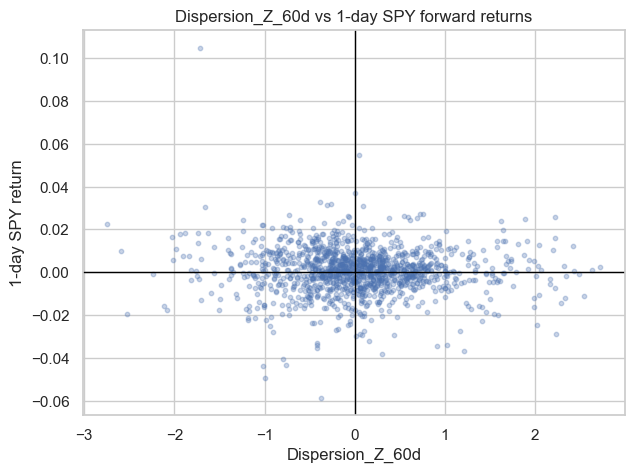

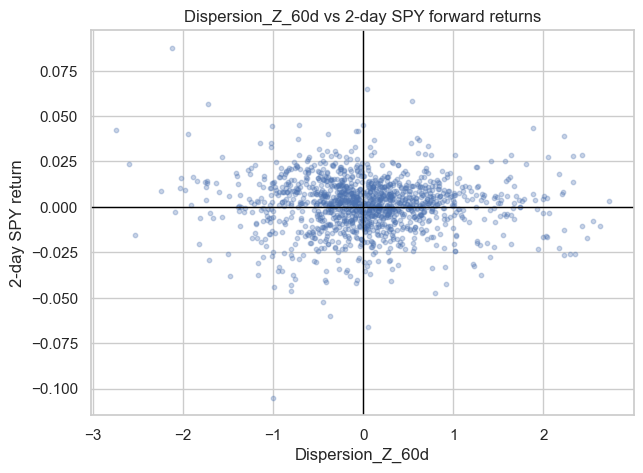

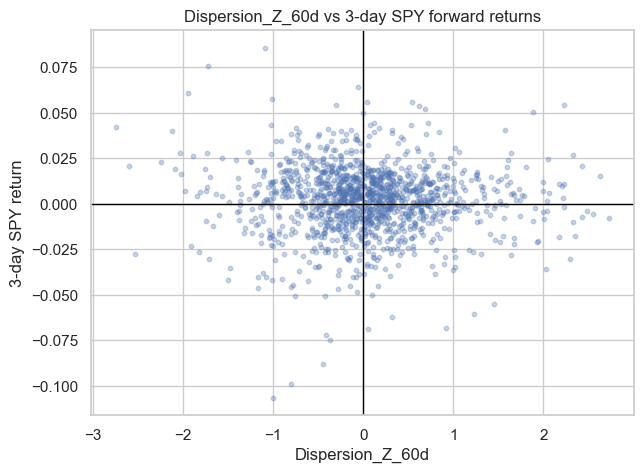

In [70]:
# Cell 12 – Optional: scatterplots

plt.figure(figsize=(7, 5))
plt.scatter(df_bt["Dispersion_Z_60d"], df_bt["ret_1d"], alpha=0.3, s=10)
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Dispersion_Z_60d")
plt.ylabel("1-day SPY return")
plt.title("Dispersion_Z_60d vs 1-day SPY forward returns")
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(df_bt["Dispersion_Z_60d"], df_bt["ret_2d"], alpha=0.3, s=10)
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Dispersion_Z_60d")
plt.ylabel("2-day SPY return")
plt.title("Dispersion_Z_60d vs 2-day SPY forward returns")
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(df_bt["Dispersion_Z_60d"], df_bt["ret_3d"], alpha=0.3, s=10)
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Dispersion_Z_60d")
plt.ylabel("3-day SPY return")
plt.title("Dispersion_Z_60d vs 3-day SPY forward returns")
plt.show()